### Load Data and Introduction

First we need some data to compute metrics on. For this we load an omega-prime file from an osi-trace and an OpenDRIVE map.

In [5]:
import omega_prime
import polars as pl
import altair as alt
import numpy as np


r = omega_prime.Recording.from_file(
    "../../example_files/alks_cut-in.osi", map_path="../../example_files/straight_500m.xodr"
)
r.moving_objects

{0: <omega_prime.recording.MovingObject at 0x214601e03d0>,
 1: <omega_prime.recording.MovingObject at 0x214601e0550>}

This recording contains two objects. The data of the trajectories is stored in `r.df` in form of a polars dataframe that has a column for each timestamp, object combination.

In [6]:
r.df.head()

total_nanos,idx,x,y,z,vel_x,vel_y,vel_z,acc_x,acc_y,acc_z,length,width,height,roll,pitch,yaw,type,role,subtype,frame,vel,acc,coords,geometry,polygon
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,u32,f64,f64,"array[f64, (1, 5, 2)]",binary,object
0,0,31.4,-1.535,0.75,20.0,0.0,0.0,0.0,0.0,0.0,5.04,2.0,1.5,0.0,0.0,0.0,2,0,4,0,20.0,0.0,"[[[33.92, -0.535], [33.92, -2.535], … [33.92, -0.535]]]","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\x00\x00\x00\x8f\xc2\xf5@@\x1e\x85\xebQ\xb8\x1e\xe1\xbf\x00\x00\x00\x8f\xc2\xf5@@H\xe1z\x14\xaeG\x04\xc0\x00\x00\x00\xaeG\xe1<@H\xe1z\x14\xaeG\x04""…","POLYGON ((33.919999957084656 -0.5349999999999999, 33.919999957084656 -2.535, 28.87999999523163 -2.535, 28.87999999523163 -0.5349999999999999, 33.919999957084656 -0.5349999999999999))"
0,1,51.45,1.535001,0.75,17.0,0.000006,0.0,0.0,0.0,0.0,5.04,2.0,1.5,0.0,0.0,3.4641e-7,2,0,4,0,17.0,0.0,"[[[53.97, 2.535001], [53.97, 0.535001], … [53.97, 2.535001]]]","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\xd8\x16\x18\xf3(\xfcJ@\xc6\x0e\x10\xcd\xaeG\x04@\xe5\xe8\xe7\xf8(\xfcJ@N?@4\xbb\x1e\xe1?\x10\xe9\xe7@\x0awH@\x9e\x8e\xec\x8a\xb7\x1e\xe1""…","POLYGON ((53.969999682199784 2.5350013752484726, 53.9700003750202 0.5350013752485923, 48.93000041316748 0.5349996293411612, 48.92999972034706 2.5349996293410415, 53.969999682199784 2.5350013752484726))"
33000000,0,32.06,-1.535,0.75,20.0,0.0,0.0,1.0766e-13,0.0,0.0,5.04,2.0,1.5,0.0,0.0,0.0,2,0,4,1,20.0,1.0766e-13,"[[[34.58, -0.535], [34.58, -2.535], … [34.58, -0.535]]]","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\x14\xaeGp=JA@\x1e\x85\xebQ\xb8\x1e\xe1\xbf\x14\xaeGp=JA@H\xe1z\x14\xaeG\x04\xc0(\\x8fp=\x8a=@H\xe1z\x14\xaeG\x04""…","POLYGON ((34.57999995708465 -0.5349999999999999, 34.57999995708465 -2.535, 29.539999995231625 -2.535, 29.539999995231625 -0.5349999999999999, 34.57999995708465 -0.5349999999999999))"
33000000,1,52.011,1.535001,0.75,17.0,0.0,0.0,3.0790e-11,-0.000178,0.0,5.04,2.0,1.5,0.0,0.0,3.4641e-7,2,0,4,1,17.0,0.000178,"[[[54.531, 2.535001], [54.531, 0.535001], … [54.531, 2.535001]]]","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\x03\x9e.\xcc\xf7CK@\xc6\x0e\x10\xcd\xaeG\x04@\x10p\xfe\xd1\xf7CK@N?@4\xbb\x1e\xe1?;p\xfe\x19\xd9\xbeH@\x9e\x8e\xec\x8a\xb7\x1e\xe1""…","POLYGON ((54.530999682199784 2.5350013752484726, 54.5310003750202 0.5350013752485923, 49.49100041316748 0.5349996293411612, 49.49099972034706 2.5349996293410415, 54.530999682199784 2.5350013752484726))"
66000000,0,32.72,-1.535,0.75,20.0,0.0,0.0,0.0,0.0,0.0,5.04,2.0,1.5,0.0,0.0,0.0,2,0,4,2,20.0,0.0,"[[[35.24, -0.535], [35.24, -2.535], … [35.24, -0.535]]]","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00)\\x8fQ\xb8\x9eA@\x1e\x85\xebQ\xb8\x1e\xe1\xbf)\\x8fQ\xb8\x9eA@H\xe1z\x14\xaeG\x04\xc0R\xb8\x1e333>@H\xe1z\x14\xaeG\x04""…","POLYGON ((35.239999957084656 -0.5349999999999999, 35.239999957084656 -2.535, 30.19999999523163 -2.535, 30.19999999523163 -0.5349999999999999, 35.239999957084656 -0.5349999999999999))"


If you just want to compute a single metric, you can do it any way you want just using the dataframe. Our experience has shown, that when computing a lot of different metrics or identifing scenarios (which can be seen as a special kind of metric). Often some metrics depend on other metrics or inbetween values and so on. Thats why we suggest using the `omega_prime.metrics.MetricManager` with `omega_prime.metrics.Metric`. 
These help you to define metrics with a single function and settings its outputs and dependencies. Then the manager handles the sorting and execution of these metrics. Key here is, that base you calculation on polars dataframes. Then the metrics manager is able to utilize [polars Lazy API](https://docs.pola.rs/user-guide/concepts/lazy-api/lazy) to derive an efficient computation of the metrics with minimal double computation. 

## Create a metric

You can create a metric by defining a function like the following and decorating it with the `@omega_prime.metrics.metric()` decorator.
create a function that takes the dataframe from a Recording (`Recording._df`) and returns the same dataframe and a dictonary with additional dataframes (dictionary needs to be always return but can be empty if necessary). Decorate it with `@omega_prime.metrics.metric()` and add it to your `MetricManager`

In [7]:
@omega_prime.metrics.metric(computes_properties=["test_property"])
def compute_stuff(df, /) -> tuple[pl.LazyFrame, dict[str, pl.LazyFrame]]:
    return df, {"test_property": df.group_by("idx").agg(pl.col("idx").count().alias("count"))}


compute_stuff

Metric(compute_func=<function compute_stuff at 0x000002145FD1ECA0>, computes_columns=[], computes_properties=['test_property'], requires_columns=[], requires_properties=[], computes_intermediate_columns=[], computes_intermediate_properties=[], _parameters=[])

By using the decorator you have turned the simple function into an object of class `omega_prime.metrics.Metric`. The function must always have as a first argument a dataframe (which when using the MetricsManager is the dataframe of the recording). Then there needs to be a `/` to ensure that all later parameters can only be accessed through keyword arguments. The function recieves the DataFrame as a LazyFrame. You can do you operations and add columns to the original dataframe (one column per timestep and object combination) and return that as the first value. Not all metrics fit that pattern. In these cases you should add those as a dictonary to the output where the key is an arbitrary name and the value is a polars dataframe. This was done in with the `test_property`. Make sure that your function always returns `df, {...}`. The dictonary can be empty if the metric does not create anything fitting it. 
We call the dictionary entries properties.
To let the MetricsManager know which columns the metric is adding to the dataframe or which properties it is going to add we list them in the decorator under `computes_columns` and `computes_properties`. 
Likewise, if our metric function requires columns or properties of other metrics, we must also list them in the decorator. 
We do that under `requires_columns` and `requires_properties`.
If your function requires properties of other metrics, you must name them in the function header after the `/`. 
Your metric can have other attributes that are also defined in the header of the function after `/`. These must not be listed in the decorator. 
We call those parameters. 
You can set defaults as usual or set no default. If so you need to specify those parameters when actually calling the computation of metrics.
Before explaining the metrics manager, lets see how the metric works. By just calling the metrics object:

In [8]:
compute_stuff(r.df)

(<LazyFrame at 0x214601BFB90>, {'test_property': <LazyFrame at 0x214601BF210>})

We see that it returned the required original dataframe (but automatically turned into a lazy frame) and a dictonary with lazy dataframes. Each metric does that. 
The `MetricManager` handles the computation of multiple metrics at ones. We create an object of the MetricManager listing all metrics we want to compute:

In [9]:
mm = omega_prime.metrics.MetricManager(
    metrics=[compute_stuff],
)
mm

computes columns: [] - computes properties ['test_property'] - parameters []

We can see that the manager will compute the properties `test_property` and will not add any columns to the `r.df` dataframe.

In [10]:
df, metrics_dict = mm.compute(r)
metrics_dict

{'test_property': shape: (2, 2)
 ┌─────┬───────┐
 │ idx ┆ count │
 │ --- ┆ ---   │
 │ i64 ┆ u32   │
 ╞═════╪═══════╡
 │ 0   ┆ 305   │
 │ 1   ┆ 305   │
 └─────┴───────┘}

The function `.compute` takes an `omega_prime.Recording` (and parameters required by the metrics) and, same as the metrics itself, returns the dataframe in `r.df` and the properties dictionary. But now off course the combined result of all used metrics

## MetricManager with multiple metrics

The usefullness of the MetricsManager comes into play, when we use multiple metrics. Omega-prime has already some metrics defined. Lets create a MetricsManager using those:

In [11]:
mm = omega_prime.metrics.MetricManager(
    metrics=[
        omega_prime.metrics.timegaps_and_min_timgaps,
        omega_prime.metrics.vel,
        omega_prime.metrics.distance_traveled,
        omega_prime.metrics.p_timegaps_and_min_p_timgaps,
    ],
)
mm

computes columns: ['vel', 'distance_traveled'] - computes properties ['timegaps', 'min_timegaps', 'p_timegaps', 'min_p_timegaps'] - parameters ['time_buffer=2000000000.0', 'ego_id']

We can see that the `MetricsManager` will add the columns `['vel', 'distance_traveled']` to the DataFrame of the recording and return a properties dictionary with the dataframes `['timegaps', 'min_timegaps', 'p_timegaps', 'min_p_timegaps']`.
For the computation of metrics, the parameters `time_buffer` and `ego_id` are requried. `time_buffer` has a default values, wheras we need to set `ego_id` for each computation. 
We always use `ego_id` to define the perspective of the metric we are taking. 
So `ego_id` is the idx of the vehicle whos perspective we are taking for the computation of the metric.
If set, it is usually the `host_vehicle_idx`.

Internally, the metrics manager derives an ordering of compuation of metrics, that fit the set dependencies. You can plot the derived ordering like:

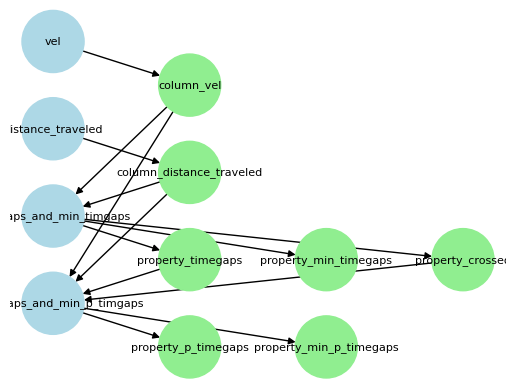

In [12]:
mm.plot_dependencies();

Blue are the metrics and green the columns or properties. An arrow from metric to column/property indicates that the metric computes them, whereas the other way around indicates that the metric is depending on those.

To compute the metric we just call `compute` again.

In [13]:
df, metrics = mm.compute(r, ego_id=0, time_buffer=10e9)
list(metrics.keys())

['timegaps', 'min_timegaps', 'p_timegaps', 'min_p_timegaps']

As you can see above, the properties `['timegaps', 'min_timegaps', 'p_timegaps', 'min_p_timegaps']` were computed by the Manger.
And the return DataFrame is the DataFrame from the recording with the columns `vel` and `distance_traveled` added.

In [17]:
df.head()

total_nanos,idx,x,y,z,vel_x,vel_y,vel_z,acc_x,acc_y,acc_z,length,width,height,roll,pitch,yaw,type,role,subtype,frame,vel,acc,coords,geometry,polygon,distance_traveled
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,u32,f64,f64,"array[f64, (1, 5, 2)]",binary,object,f64
0,0,31.4,-1.535,0.75,20.0,0.0,0.0,0.0,0.0,0.0,5.04,2.0,1.5,0.0,0.0,0.0,2,0,4,0,20.0,0.0,"[[[33.92, -0.535], [33.92, -2.535], … [33.92, -0.535]]]","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\x00\x00\x00\x8f\xc2\xf5@@\x1e\x85\xebQ\xb8\x1e\xe1\xbf\x00\x00\x00\x8f\xc2\xf5@@H\xe1z\x14\xaeG\x04\xc0\x00\x00\x00\xaeG\xe1<@H\xe1z\x14\xaeG\x04""…","POLYGON ((33.919999957084656 -0.5349999999999999, 33.919999957084656 -2.535, 28.87999999523163 -2.535, 28.87999999523163 -0.5349999999999999, 33.919999957084656 -0.5349999999999999))",0.0
0,1,51.45,1.535001,0.75,17.0,0.000006,0.0,0.0,0.0,0.0,5.04,2.0,1.5,0.0,0.0,3.4641e-7,2,0,4,0,17.0,0.0,"[[[53.97, 2.535001], [53.97, 0.535001], … [53.97, 2.535001]]]","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\xd8\x16\x18\xf3(\xfcJ@\xc6\x0e\x10\xcd\xaeG\x04@\xe5\xe8\xe7\xf8(\xfcJ@N?@4\xbb\x1e\xe1?\x10\xe9\xe7@\x0awH@\x9e\x8e\xec\x8a\xb7\x1e\xe1""…","POLYGON ((53.969999682199784 2.5350013752484726, 53.9700003750202 0.5350013752485923, 48.93000041316748 0.5349996293411612, 48.92999972034706 2.5349996293410415, 53.969999682199784 2.5350013752484726))",0.0
33000000,0,32.06,-1.535,0.75,20.0,0.0,0.0,1.0766e-13,0.0,0.0,5.04,2.0,1.5,0.0,0.0,0.0,2,0,4,1,20.0,1.0766e-13,"[[[34.58, -0.535], [34.58, -2.535], … [34.58, -0.535]]]","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\x14\xaeGp=JA@\x1e\x85\xebQ\xb8\x1e\xe1\xbf\x14\xaeGp=JA@H\xe1z\x14\xaeG\x04\xc0(\\x8fp=\x8a=@H\xe1z\x14\xaeG\x04""…","POLYGON ((34.57999995708465 -0.5349999999999999, 34.57999995708465 -2.535, 29.539999995231625 -2.535, 29.539999995231625 -0.5349999999999999, 34.57999995708465 -0.5349999999999999))",0.66
33000000,1,52.011,1.535001,0.75,17.0,0.0,0.0,3.0790e-11,-0.000178,0.0,5.04,2.0,1.5,0.0,0.0,3.4641e-7,2,0,4,1,17.0,0.000178,"[[[54.531, 2.535001], [54.531, 0.535001], … [54.531, 2.535001]]]","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\x03\x9e.\xcc\xf7CK@\xc6\x0e\x10\xcd\xaeG\x04@\x10p\xfe\xd1\xf7CK@N?@4\xbb\x1e\xe1?;p\xfe\x19\xd9\xbeH@\x9e\x8e\xec\x8a\xb7\x1e\xe1""…","POLYGON ((54.530999682199784 2.5350013752484726, 54.5310003750202 0.5350013752485923, 49.49100041316748 0.5349996293411612, 49.49099972034706 2.5349996293410415, 54.530999682199784 2.5350013752484726))",1.221
66000000,0,32.72,-1.535,0.75,20.0,0.0,0.0,0.0,0.0,0.0,5.04,2.0,1.5,0.0,0.0,0.0,2,0,4,2,20.0,0.0,"[[[35.24, -0.535], [35.24, -2.535], … [35.24, -0.535]]]","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00)\\x8fQ\xb8\x9eA@\x1e\x85\xebQ\xb8\x1e\xe1\xbf)\\x8fQ\xb8\x9eA@H\xe1z\x14\xaeG\x04\xc0R\xb8\x1e333>@H\xe1z\x14\xaeG\x04""…","POLYGON ((35.239999957084656 -0.5349999999999999, 35.239999957084656 -2.535, 30.19999999523163 -2.535, 30.19999999523163 -0.5349999999999999, 35.239999957084656 -0.5349999999999999))",1.881


The following plots show the computed timegaps and predictated timegaps for the recording.

In [15]:
(
    alt.Chart(metrics["p_timegaps"]).mark_line().encode(alt.X("total_nanos_ego:Q"), alt.Y("p_timegap"), color="idx:N")
    + alt.Chart(metrics["timegaps"])
    .mark_line(strokeDash=[10, 2])
    .encode(alt.X("total_nanos_ego:Q"), alt.Y("timegap"), color="idx:N")
    + alt.Chart(metrics["min_timegaps"])
    .mark_rule(strokeDash=[1, 1])
    .encode(
        alt.Y("min_timegap"),
        color="idx:N",
    )
    .properties(title="timegap")
).interactive()

alt.LayerChart(...)

In [16]:
max_nanos = np.max(metrics["p_timegaps"].select(pl.max("total_nanos_ego", "total_nanos")).to_numpy())
min_nanos = np.min(metrics["p_timegaps"].select(pl.min("total_nanos_ego", "total_nanos")).to_numpy())

(
    alt.Chart(metrics["timegaps"].select(pl.col("total_nanos_ego", "total_nanos", "idx")))
    .mark_line(strokeDash=[1, 1])
    .encode(alt.X("total_nanos_ego:Q"), alt.Y("total_nanos:Q"), color="idx:N")
    + alt.Chart()
    .mark_rule(color="red")
    .encode(x=alt.datum(min_nanos), x2=alt.datum(max_nanos), y2=alt.datum(max_nanos), y=alt.datum(min_nanos))
    + (
        alt.Chart(metrics["p_timegaps"].select(pl.col("total_nanos_ego", "total_nanos", "idx")))
        .mark_line()
        .encode(alt.X("total_nanos_ego:Q"), alt.Y("total_nanos:Q"), color="idx:N")
    )
).properties(title="time of smallest timegap").interactive()

alt.LayerChart(...)